In [1]:
import numpy as np
import pandas as pd
df_ner = pd.read_csv("./ner.csv", encoding ="cp1252", error_bad_lines=False)
df_ner.dropna(inplace=True)
dataset = df_ner.loc[:,["lemma","word","pos","tag","prev-iob"]]
dataset.head()

b'Skipping line 281837: expected 25 fields, saw 34\n'


,lemma,word,pos,tag,prev-iob
0,thousand,Thousands,NNS,O,__START1__
1,of,of,IN,O,O
2,demonstr,demonstrators,NNS,O,O
3,have,have,VBP,O,O
4,march,marched,VBN,O,O


In [7]:
n_used = 100000 #data to use
dataX,dataY = [],[]
sentence, labels_sentence = [], []
lemmas,labels = set(), set()  #uniques
for fila in dataset.values[:n_used]:
    if fila[-1]=="__START1__": 
        dataX.append(sentence)
        dataY.append(labels_sentence)
        sentence= []
        labels_sentence = []
    lemmas.add(fila[0])
    labels.add(fila[3])
    sentence.append(fila[0]) #add lemma
    labels_sentence.append(fila[3]) #TAG
dataX = dataX[1:]
dataY = dataY[1:]

In [8]:
n_labels = len(labels)
lab2idx = {t: i for i, t in enumerate(labels)}
dataY = [[lab2idx[ner] for ner in ner_tags ] for ner_tags in dataY]

In [4]:
from gensim.models import Word2Vec
EMBEDDING_DIM = 32
window_size = 5
nb_epoch = 5
batch_size = 6000
model = Word2Vec(dataX, size=EMBEDDING_DIM, window=window_size,batch_words=batch_size,iter=nb_epoch,
                 min_count=3, negative=5,sg=1) #sg=1 mean skip-gram
model

In [10]:
vocab_words = list(model.wv.vocab)
print("Tamano del vocabulario: ",len(vocab_words))

Tamano del vocabulario:  3144


In [5]:
embeddings_index = {vocab_word: model.wv[vocab_word] for vocab_word in model.wv.vocab}

In [9]:
lemma2idx = {w: i for i, w in enumerate(lemmas)} #Converting text to numbers
n_lemmas = len(lemmas)

dataX = [[lemma2idx[lemma] for lemma in sentence ] for sentence in dataX]

In [26]:
embedding_matrix = np.zeros((n_lemmas+1, EMBEDDING_DIM))
for word, i in lemma2idx.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: #if word does not has embedding
        embedding_matrix[i] = embedding_vector
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ..., 
       [ 0.05347466,  0.0790691 , -0.12822857, ..., -0.26420334,
        -0.17218229,  0.02646903],
       [ 0.10988804,  0.10135647, -0.17103973, ..., -0.37504655,
        -0.27834073,  0.06954294],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [21]:
X.shape

(4543, 34)

In [27]:
embedding_matrix.shape

(7513, 32)

In [22]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=22)

In [24]:
X_train.shape

(3180, 34)

In [29]:
embedding_matrix.shape

(7513, 32)

In [31]:
n_lemmas+=1
n_labels+=1

In [32]:
from keras.models import Sequential
from keras.layers import LSTM, Embedding, Dense, Dropout
model = Sequential()
model.add(Embedding(input_dim=n_lemmas, output_dim=EMBEDDING_DIM, input_length=34,trainable=False,
                   weights = [embedding_matrix]))
model.add(LSTM(units=100,return_sequences=True))
model.add(Dropout(0.2))
model.add(Dense(n_labels, activation='softmax'))
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=128)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 34, 32)            240416    
_________________________________________________________________
lstm_1 (LSTM)                (None, 34, 100)           53200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 34, 100)           0         
_________________________________________________________________
dense_1 (Dense)              (None, 34, 18)            1818      
Total params: 295,434
Trainable params: 55,018
Non-trainable params: 240,416
_________________________________________________________________
Train on 3180 samples, validate on 1363 samples
Epoch 1/10
3180/3180 [==============================] - 4s 1ms/step - loss: 2.0487 - val_loss: 1.6018
Epoch 2/10
3180/3180 [==============================] - 2s 547us/step - loss: 1.3990 - val_loss: 1.1465
Epoch 3/1

In [1]:
from keras.datasets import mnist
import numpy as np
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train[:,:,:,None] #add channels
x_test = x_test[:,:,:,None]
img_rows, img_cols,channel = x_train.shape[1:]
original_img_size = (img_rows, img_cols,channel) # input image dimensions

Using TensorFlow backend.


In [2]:
x_train = x_train.astype('float32') / 255. #and x_test
x_test = x_test.astype('float32') / 255. #and x_test

#...#Define here your validation set
import keras
Y_train = keras.utils.to_categorical(y_train, 10)
Y_test = keras.utils.to_categorical(y_test, 10)

In [41]:
x_train.max()

1.0

In [69]:
from keras.layers import Input, Dense, Flatten,Reshape
from keras.models import Model
input_img = Input(shape=original_img_size)
input_fl = Flatten()(input_img) #to get a vector representation
encoded = Dense(32, activation='relu')(input_fl)
decoded = Dense(np.prod(original_img_size), activation='sigmoid')(encoded)
decoded = Reshape(original_img_size)(decoded)
autoencoder = Model(inputs=input_img, outputs=decoded)
encoder = Model(inputs=input_img, outputs=encoded)
autoencoder.compile(optimizer='rmsprop', loss='binary_crossentropy')
autoencoder.fit(x_train,x_train,epochs=30,batch_size=32,validation_data=(x_test,x_test))
autoencoder.save('basic_autoencoder.h5')

Train on 60000 samples, validate on 10000 samples
Epoch 1/30
 5216/60000 [=>............................] - ETA: 8s - loss: 0.2853

KeyboardInterrupt: 

In [68]:
from keras.layers import Input,Conv2D,Flatten,Dense,MaxPooling2D, UpSampling2D
input_img = Input(shape=original_img_size)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)
before_F_shape =  (x.shape[1].value, x.shape[2].value, x.shape[3].value)
x = Flatten()(x)
encoded = Dense(32, activation='relu')(x)
x = Dense(np.prod(before_F_shape),activation='relu')(encoded)
x = Reshape(before_F_shape)(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='rmsprop', loss='binary_crossentropy')
autoencoder.summary()
autoencoder.fit(x_train,x_train,epochs=30,batch_size=32,validation_data=(x_test,x_test))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_26 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 7, 7, 32)          0         
_________________________________________________________________
flatten_20 (Flatten)         (None, 1568)              0         
_________________________________________________________________
dense_29 (Dense)             (None, 32)                50208     
__________

KeyboardInterrupt: 

(7, 7, 32)

In [26]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 32)                25120     
_________________________________________________________________
dense_14 (Dense)             (None, 784)               25872     
_________________________________________________________________
reshape_6 (Reshape)          (None, 28, 28, 1)         0         
Total params: 50,992
Trainable params: 50,992
Non-trainable params: 0
_________________________________________________________________


In [ ]:
??

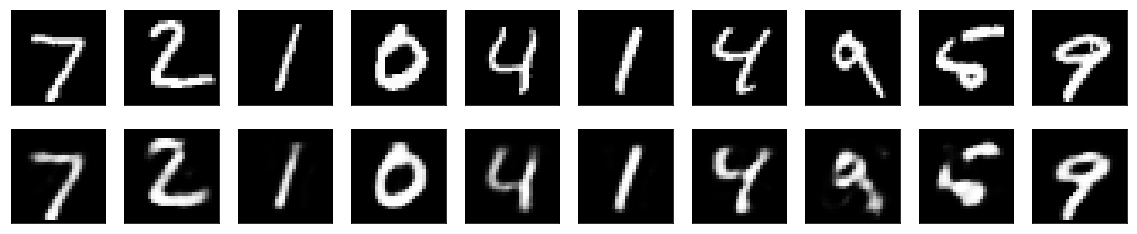

In [45]:
#encoded_test = encoder.predict(x_test)
#decoded_test = decoder.predict(encoded_test)
decoded_test = autoencoder.predict(x_test)
import matplotlib.pyplot as plt
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28),cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_test[i].reshape(28, 28),cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [10]:
from keras.layers import Input,Conv2D,Flatten,Dense,MaxPool2D
from keras.models import Model
filters = 32 # number of convolutional filters to use
num_conv = 3 # convolution kernel size
intermediate_dim = 128

#cambia
latent_dim = 10

x = Input(shape=original_img_size)
conv_1 = Conv2D(filters,kernel_size=num_conv,padding='same', activation='relu')(x)
conv_2 = Conv2D(filters,kernel_size=num_conv,padding='same', activation='relu')(conv_1)
conv_3 = Conv2D(filters*2, kernel_size=num_conv, padding='same', activation='relu', strides=2)(conv_2)
flat = Flatten()(conv_3)
hidden = Dense(intermediate_dim, activation='relu')(flat)

#cambio..
logits_z = Dense(latent_dim,activation='linear')(hidden) #log(p(z))
encoder = Model(x, logits_z) # build a model to project inputs on the latent space


In [11]:
import keras.backend as K
from keras.layers import Reshape,Conv2DTranspose,Activation
shape_before_flattening = K.int_shape(conv_3)[1:] # we instantiate these layers separately to reuse them later
decoder_hid = Dense(intermediate_dim, activation='relu')
decoder_upsample = Dense(np.prod(shape_before_flattening), activation='relu')
decoder_reshape = Reshape(shape_before_flattening)
decoder_deconv_1 = Conv2DTranspose(filters,kernel_size=num_conv, padding='same',strides=2,activation='relu')
decoder_deconv_2 = Conv2DTranspose(filters,kernel_size=num_conv,padding='same', activation='relu')
decoder_mean_squash = Conv2DTranspose(channel, kernel_size=num_conv,padding='same', activation='sigmoid')

In [14]:
def sample_gumbel(shape,eps=K.epsilon()):
    """Inverse Sample function from Gumbel(0, 1)"""
    U = K.random_uniform(shape, 0, 1)
    return - K.log( -K.log(U + eps) + eps)
        
def sampling(logits_z):
    """ Perform a Gumbel-Softmax sampling"""
    tau = K.variable(2/3, name="temperature") 
    z = logits_z + sample_gumbel(K.shape(logits_z)) # logits + gumbel noise
    return keras.activations.softmax( z/tau )    

from keras.layers import Lambda
z = Lambda(sampling, output_shape=(latent_dim,))(logits_z)
#para arriba cambio...

hid_decoded = decoder_hid(z)
up_decoded = decoder_upsample(hid_decoded)
reshape_decoded =  decoder_reshape(up_decoded)
deconv_1_decoded = decoder_deconv_1(reshape_decoded)
x_decoded_relu = decoder_deconv_2(deconv_1_decoded)
x_decoded_mean_squash = decoder_mean_squash(x_decoded_relu)
vae_norm = Model(x, x_decoded_mean_squash) # instantiate VAE model
vae_norm.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
flatten_2 (Flatten)          (None, 12544)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               1605760   
_________________________________________________________________
dense_6 (Dense)              (None, 10)                1290      
__________

In [15]:
choised_loss =  keras.metrics.binary_crossentropy(K.flatten(x),K.flatten(x_decoded_mean_squash))
reconstruction_loss = img_rows * img_cols * channel* choised_loss

#KL cambia:
dist =  keras.activations.softmax(logits_z) # =p(z)
dist_neg_entropy = K.sum(dist * K.log(dist + K.epsilon()), axis=1)
kl_disc_loss =  np.log(latent_dim) + dist_neg_entropy #discrete KL-loss
vae_loss = K.mean(reconstruction_loss + kl_disc_loss)

vae_norm.add_loss(vae_loss)
vae_norm.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
flatten_2 (Flatten)          (None, 12544)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               1605760   
_________________________________________________________________
dense_6 (Dense)              (None, 10)                1290      
__________

In [153]:
batch_size = 64
epochs =  25
vae_norm.compile(optimizer='rmsprop')
vae_norm.fit(x_train,epochs=epochs, batch_size=batch_size,validation_data=(x_test, None))

/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:3: UserWarning: Output "conv2d_transpose_6" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "conv2d_transpose_6" during training.
  app.launch_new_instance()


Train on 60000 samples, validate on 10000 samples
Epoch 1/25
60000/60000 [==============================] - 18s 301us/step - loss: 138.1076 - val_loss: 138.6182
Epoch 2/25
60000/60000 [==============================] - 17s 280us/step - loss: 137.1350 - val_loss: 139.8848
Epoch 3/25
60000/60000 [==============================] - 17s 281us/step - loss: 136.3050 - val_loss: 135.7248
Epoch 4/25
60000/60000 [==============================] - 17s 280us/step - loss: 135.5400 - val_loss: 136.2309
Epoch 5/25
60000/60000 [==============================] - 17s 279us/step - loss: 134.9025 - val_loss: 134.9311
Epoch 6/25
60000/60000 [==============================] - 17s 279us/step - loss: 134.4601 - val_loss: 135.2788
Epoch 7/25
60000/60000 [==============================] - 17s 279us/step - loss: 133.7722 - val_loss: 133.9731
Epoch 8/25
60000/60000 [==============================] - 17s 282us/step - loss: 133.3055 - val_loss: 133.6667
Epoch 9/25
60000/60000 [==============================] - 17s 

In [154]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - x.max(axis=-1,keepdims=True) )
    return e_x / e_x.sum(axis=-1, keepdims=True)
p_z_train = softmax(encoder.predict(x_train))
p_z_test = softmax(encoder.predict(x_test))
y_train_pred = p_z_train.argmax(axis=-1)
y_test_pred = p_z_test.argmax(axis=-1)
p_z_test

array([[9.93214577e-09, 3.42115709e-05, 3.34711804e-05, ...,
        9.18326557e-01, 7.88376778e-02, 1.22381802e-08],
       [5.01510799e-02, 1.18385833e-04, 1.04509264e-01, ...,
        2.30292767e-06, 2.50481698e-05, 2.21619487e-01],
       [4.96984764e-09, 2.85342723e-01, 7.14640677e-01, ...,
        8.22795391e-06, 9.44979983e-10, 4.77221238e-06],
       ...,
       [2.92682046e-07, 3.96850646e-01, 3.09091178e-03, ...,
        4.07346815e-01, 6.24903696e-05, 1.12699415e-03],
       [1.94816457e-05, 1.52378857e-06, 4.45192470e-08, ...,
        6.37474470e-03, 8.71460512e-03, 2.05271999e-06],
       [3.02969944e-04, 6.97063399e-07, 1.66004733e-03, ...,
        5.49713430e-09, 4.10732959e-08, 1.04517244e-06]], dtype=float32)

In [155]:
from sklearn.metrics import normalized_mutual_info_score
print(normalized_mutual_info_score(y_train, y_train_pred))
print(normalized_mutual_info_score(y_test, y_test_pred))


0.31587453023976225
0.323335570035452


In [156]:
decoder_input = Input(shape=(latent_dim,))
_hid_decoded = decoder_hid(decoder_input)
_up_decoded = decoder_upsample(_hid_decoded)
_reshape_decoded = decoder_reshape(_up_decoded)
_deconv_1_decoded = decoder_deconv_1(_reshape_decoded)
_x_decoded_relu = decoder_deconv_2(_deconv_1_decoded)
_x_decoded_mean_squash = decoder_mean_squash(_x_decoded_relu)
generator = Model(decoder_input, _x_decoded_mean_squash) 

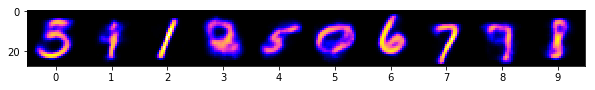

In [157]:
predictions =np.zeros((img_cols * 1 ,img_cols* latent_dim))
for i in range(latent_dim):
    activate_aux = np.zeros((1,10))
    activate_aux[:,i] = 1 #activate a class
    predictions[:, i * img_cols: (i + 1) * img_cols] = np.squeeze(generator.predict(activate_aux))
    
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
plt.imshow(predictions, cmap='gnuplot2')
pos = np.arange(img_cols/2, img_cols*latent_dim, img_cols)
plt.xticks(pos,range(latent_dim))
plt.show()

In [ ]:
#https://arxiv.org/pdf/1511.00561v2.pdf 

model = Sequential()

#ENCODER PART
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
#BN??
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), strides=(2,2)))

model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), strides=(2,2)))

model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), strides=(2,2)))

model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), strides=(2,2)))

#quizas sacar..
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
#model.add(MaxPooling2D((2, 2), strides=(2,2))) -- debe terminar sin pooling

#reverse..

#DECODER PART
#model.add(UpSampling2d((2, 2), strides=(2,2)))
model.add(Conv2DTranspose(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2DTranspose(256, (3, 3), activation='relu', padding='same'))

model.add(UpSampling2d((2, 2), strides=(2,2)))
model.add(Conv2DTranspose(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2DTranspose(256, (3, 3), activation='relu', padding='same'))

model.add(UpSampling2d((2, 2), strides=(2,2)))
model.add(Conv2DTranspose(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2DTranspose(128, (3, 3), activation='relu', padding='same'))

model.add(UpSampling2d((2, 2), strides=(2,2)))
model.add(Conv2DTranspose(64, (3, 3), activation='relu', padding='same'))
model.add(Conv2DTranspose(64, (3, 3), activation='relu', padding='same'))

model.add(UpSampling2d((2, 2), strides=(2,2)))
model.add(Conv2DTranspose(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2DTranspose(32, (3, 3), activation='relu', padding='same'))

model.add(UpSampling2d((2, 2), strides=(2,2)))
#una que lleve a size original??

model.add(Activation('softmax')) #debe ir softmax al final: pixel-wise classification

model.summary()
